# BERT Finetuning on WikiQA

## Setting up the environment

In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
!mkdir -p /scratch/sagarsj42/hf-datasets

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/sagarsj42/hf-datasets'

## Imports

In [2]:
import string
import copy

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers
from transformers import BertTokenizer, BertModel

2021-12-11 11:30:32.628285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 11:30:32.628321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
transformers.logging.set_verbosity_error()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Create, filter datasets

In [4]:
# Copied from explore_wikiqa.ipynb
def get_valid_questions(wikiqa):
    question_status = dict()

    for split in wikiqa:
        split_dataset = wikiqa[split]
        n_samples = len(split_dataset)

        for i in range(n_samples):
            qid = split_dataset[i]['question_id']
            label = split_dataset[i]['label']
            if qid not in question_status:
                question_status[qid] = label
            else:
                question_status[qid] = max(question_status[qid], label)

    valid_questions = set([qid for qid in question_status if question_status[qid] > 0])
    
    return valid_questions

In [5]:
class WikiqaDataset(Dataset):
    def __init__(self, wikiqa, tokenizer, max_length):
        super(WikiqaDataset, self).__init__()
        self.wikiqa = wikiqa
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.wikiqa)
    
    def __getitem__(self, idx):
        sample = self.wikiqa[idx]
        question = sample['question'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        sentence = sample['answer'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        label = torch.zeros(2)
        label[sample['label']] = 1.0
        
        input_enc = tokenizer(text=question, text_pair=sentence, 
                              add_special_tokens=True, truncation=True, padding='max_length', 
                              max_length=self.max_length, 
                              return_tensors='pt', return_attention_mask=True)
        
        return (sample['question_id'], question, sentence, 
                input_enc['input_ids'].flatten(), input_enc['attention_mask'].flatten(), 
                input_enc['token_type_ids'].flatten(), 
                label)

## Architecture used for finetuning

In [6]:
class BertQA(nn.Module):
    def __init__(self, encoder):
        super(BertQA, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(512, 2),
            nn.Dropout(p=0.15),
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

## Load & filter WikiQA

In [7]:
wikiqa = datasets.load_dataset('wiki_qa')
valid_questions = get_valid_questions(wikiqa)
wikiqa_f = wikiqa.filter(lambda sample: sample['question_id'] in valid_questions)

wikiqa_f

Using custom data configuration default
Reusing dataset wiki_qa (/scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2351
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 1130
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 8672
    })
})

## Load tokenizer & encoder for BERT

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = BertModel.from_pretrained('bert-base-uncased')
encoder

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Distribution of tokenized lengths

In [9]:
tok_lengths = list()

for sample in wikiqa_f['train']:
    question = sample['question']
    sentence = sample['answer']
    tok_len = len(tokenizer(text=question, text_pair=sentence)['input_ids'])
    tok_lengths.append(tok_len)
    
len(tok_lengths)

8672

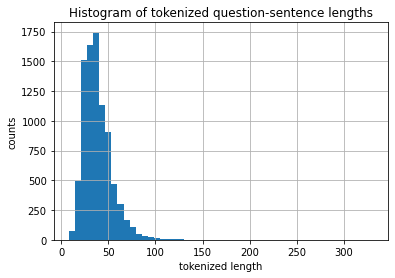

In [10]:
plt.hist(tok_lengths, density=False, bins=50)
plt.xlabel('tokenized length')
plt.ylabel('counts')
plt.title('Histogram of tokenized question-sentence lengths')
plt.grid()
plt.show()

## Setup for finetuning

In [11]:
batch_size = 16
learning_rate = 5e-6
n_epochs = 10

pos_weight=torch.tensor([1.0, 8.0], dtype=torch.float).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion

BCEWithLogitsLoss()

In [12]:
train_dataset = WikiqaDataset(wikiqa_f['train'], tokenizer, max_length=64)
dev_dataset = WikiqaDataset(wikiqa_f['validation'], tokenizer, max_length=64)
test_dataset = WikiqaDataset(wikiqa_f['test'], tokenizer, max_length=64)

len(train_dataset), len(dev_dataset), len(test_dataset)

(8672, 1130, 2351)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataloader), len(dev_dataloader), len(test_dataloader)

(542, 71, 147)

In [14]:
def train_epoch(dataloader, model, optimizer, criterion, device='cpu'):
    model.train()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        optimizer.zero_grad()
        output = model(sample[:-1])
        loss = criterion(output, sample[-1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / n_batches

def validate(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output, sample[-1])
        total_loss += loss.item()
        
    return total_loss / n_batches

def get_scores(dataloader, model, device='cpu'):
    model.eval()
    eval_results = list()
    
    for batch in dataloader:
        batch = copy.deepcopy(batch)
        batch_d = [b.to(device) for b in batch[3:6]]
        output = model(batch_d).detach()[:, 1]
        scores = nn.Sigmoid()(output)
        
        batch[-1] = batch[-1][:, 1].tolist()
        batch.append(scores.tolist())
        size = len(batch[0])
        eval_results.extend([[b[i] for b in batch] for i in range(size)])
        
    return eval_results

def get_question_label_scores(results):
    q_dict = dict()
    
    for result in results:
        qid = result[0]
        if qid in q_dict:
            q_dict[qid][1].append(result[2])
            q_dict[qid][2].append(result[6])
            q_dict[qid][3].append(result[7])
        else:
            q_dict[qid] = [result[1], [result[2]], [result[6]], [result[7]]]
            
    return q_dict

def calculate_metrics(question_scores):
    total = len(question_scores) * 1.0
    accuracy = 0
    mrr = 0.0
    all_labels = list()
    all_scores = list()
    
    for qid, values in question_scores.items():
        values = copy.deepcopy(values)
        labels = values[2]
        scores = values[3]
        all_labels.extend(labels)
        all_scores.extend(scores)
        actual = np.array(labels).argmax()
        predicted = np.array(scores).argmax()
        expected_max = scores[actual]
        scores.sort(reverse=True)
        given_rank = scores.index(expected_max) + 1
        
        if actual == predicted:
            accuracy += 1
        mrr += (1.0/given_rank)
        
    accuracy /= total
    mean_ap = average_precision_score(all_labels, all_scores)
    mrr /= total
    
    return accuracy, mean_ap, mrr

def plot_curves(train_stats, dev_stats, index, title):
    n_epochs = len(train_stats)+1
    plt.plot(range(1, n_epochs), [s[index] for s in train_stats])
    plt.plot(range(1, n_epochs), [s[index] for s in dev_stats])
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'Comparison of {title} variation over epochs')
    plt.legend(['train', 'dev'])
    plt.grid()
    plt.show()
    
    return

In [15]:
model = BertQA(encoder)
model.to(DEVICE)

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-7)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-07
    lr: 5e-06
    weight_decay: 0
)

### Complete finetuning & evaluate

In [16]:
best_mrr = float('-inf')
best_model = None
train_stats = list()
dev_stats = list()

for epoch in range(n_epochs):
    train_loss = train_epoch(train_dataloader, model, optimizer, criterion, device=DEVICE)
    dev_loss = validate(dev_dataloader, model, criterion, device=DEVICE)
    
    train_results = get_scores(train_dataloader, model, device=DEVICE)
    train_qscores = get_question_label_scores(train_results)
    train_acc, train_map, train_mrr = calculate_metrics(train_qscores)
    train_stats.append((train_loss, train_acc, train_map, train_mrr))
    
    dev_results = get_scores(dev_dataloader, model, device=DEVICE)
    dev_qscores = get_question_label_scores(dev_results)
    dev_acc, dev_map, dev_mrr = calculate_metrics(dev_qscores)
    dev_stats.append((dev_loss, dev_acc, dev_map, dev_mrr))
    
    if dev_mrr > best_mrr:
        best_mrr = dev_mrr
        best_model = copy.deepcopy(model)
    
    print(f'Epoch {epoch+1} complete. Train loss: {train_loss:.4f}, Dev loss: {dev_loss:.4f}')
    print(f'Accuracy: train = {train_acc}, dev = {dev_acc}')
    print(f'MAP: train = {train_map}, dev = {dev_map}')
    print(f'MRR: train = {train_mrr}, dev = {dev_mrr}')
    print('-'*80)
    
save_dict = {'model_params': best_model.state_dict(), 
             'train_stats': train_stats, 
             'dev_stats': dev_stats
            }
torch.save(save_dict, 'best-wikiqa-bert.pth')

Epoch 1 complete. Train loss: 0.7537, Dev loss: 0.6257
Accuracy: train = 0.5234822451317297, dev = 0.6349206349206349
MAP: train = 0.5508036827910201, dev = 0.5435061002780915
MRR: train = 0.6988010217979469, dev = 0.7497858402620305
--------------------------------------------------------------------------------
Epoch 2 complete. Train loss: 0.6109, Dev loss: 0.5883
Accuracy: train = 0.6139747995418099, dev = 0.6349206349206349
MAP: train = 0.6669284106393539, dev = 0.5817187669620989
MRR: train = 0.768989436171567, dev = 0.7521101033005795
--------------------------------------------------------------------------------
Epoch 3 complete. Train loss: 0.5329, Dev loss: 0.5824
Accuracy: train = 0.7044673539518901, dev = 0.626984126984127
MAP: train = 0.7821613504360823, dev = 0.5951014072803449
MRR: train = 0.8345388097965414, dev = 0.7600902184235518
--------------------------------------------------------------------------------
Epoch 4 complete. Train loss: 0.4410, Dev loss: 0.6026
Ac

In [17]:
save_dict = torch.load('best-wikiqa-bert.pth')
train_stats = save_dict['train_stats']
dev_stats = save_dict['dev_stats']
save_dict.keys()

dict_keys(['model_params', 'train_stats', 'dev_stats'])

In [18]:
model = BertQA(encoder)
model.load_state_dict(save_dict['model_params'], strict=False)
model.to(DEVICE)

BertQA(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [19]:
test_loss = validate(test_dataloader, model, criterion, device=DEVICE)
test_loss

0.6642930967365803

In [20]:
test_results = get_scores(test_dataloader, model, device=DEVICE)
test_qscores = get_question_label_scores(test_results)
test_acc, test_map, test_mrr = calculate_metrics(test_qscores)

print(f'Test data: Accuracy = {test_acc}, MAP = {test_map}, MRR = {test_mrr}')

Test data: Accuracy = 0.5802469135802469, MAP = 0.5263076178418589, MRR = 0.7406216782759991


## Additional visualizations

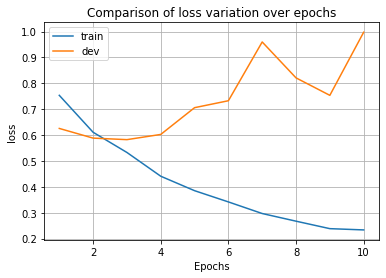

In [21]:
plot_curves(train_stats, dev_stats, 0, 'loss')

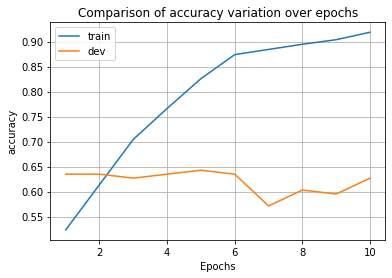

In [22]:
plot_curves(train_stats, dev_stats, 1, 'accuracy')

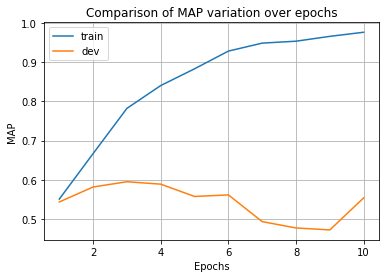

In [23]:
plot_curves(train_stats, dev_stats, 2, 'MAP')

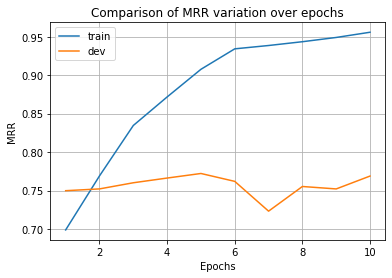

In [24]:
plot_curves(train_stats, dev_stats, 3, 'MRR')